# Ricardo and Aminata

# Data Collection + Cleaning: California Department of Education School Fiscal Services Division data

In [1]:
import pandas as pd
import glob

data_path = "/content/"

# get all Excel files
files = sorted(glob.glob(data_path + "currentexpense*.xlsx"))

column_mapping = {
    "CO": "County_Code",
    "CDS": "District_Code",
    "District Code": "District_Code",
    "DISTRICT": "District_Name",
    "District": "District_Name",
    "EDP 365": "Total_Expenditure",
    "Current Expense ADA": "Total_Expense_ADA",
    "Current Expense Per ADA": "Expense_per_Student",
    "Current Expense per ADA": "Expense_per_Student",
    "LEA Type": "District_Type"
}

data_dict = {}

for file in files:
    # Extract school year from filename
    year_str = file[-9:-5]  # Extracts "1718", "1819", etc.
    start_year = "20" + year_str[:2]  # "17" → "2017"
    end_year = "20" + year_str[2:]   # "18" → "2018"
    school_year = f"{start_year}-{end_year}"

    df = pd.read_excel(file, skiprows=9)

    # Use first row as column headers and clean metadata
    df.columns = df.iloc[0]
    df = df[1:].reset_index(drop=True)

    # Standardize column names
    df.columns = df.columns.str.replace("\n", " ").str.strip()

    # Rename columns for consistency
    df.rename(columns={col: column_mapping[col] for col in df.columns if col in column_mapping}, inplace=True)

    for col in column_mapping.values():
        if col not in df.columns:
            df[col] = pd.NA  # Assign NaN if missing
    num_cols = ["Total_Expenditure", "Total_Expense_ADA", "Expense_per_Student"]
    for col in num_cols:
        if col in df.columns:
            df[col] = df[col].astype(str).str.replace(",", "").astype(float)

    # Add School Year column
    df["School Year"] = school_year

    # Store cleaned dataframe
    data_dict[school_year] = df

# Merge all dataframes using an outer join to keep all districts
df_financial_all_years = pd.concat(data_dict.values(), ignore_index=True)

# Remove extra/unecessary 'CO Code' column
df_financial_all_years.drop(columns=["CO Code"], errors="ignore", inplace=True)
df_financial_all_years

,County_Code,District_Code,District_Name,Total_Expenditure,Total_Expense_ADA,Expense_per_Student,District_Type,School Year
0,01,61119,Alameda Unified,1.083029e+08,9066.41,11945.514831,Unified,2017-2018
1,01,61127,Albany City Unified,4.568353e+07,3537.39,12914.474279,Unified,2017-2018
2,01,61143,Berkeley Unified,1.446372e+08,9345.84,15476.109168,Unified,2017-2018
3,01,61150,Castro Valley Unified,9.267711e+07,8951.22,10353.572598,Unified,2017-2018
4,01,61168,Emery Unified,1.146818e+07,645.96,17753.696282,Unified,2017-2018
...,...,...,...,...,...,...,...,...
6550,58,72728,Camptonville Elementary,1.108568e+06,45.90,24151.800000,Elementary,2023-2024
6551,58,72736,Marysville Joint Unified,1.627392e+08,9194.94,17698.780000,Unified,2023-2024
6552,58,72744,Plumas Lake Elementary,2.372750e+07,1565.05,15160.860000,Elementary,2023-2024
6553,58,72751,Wheatland Elementary,2.687077e+07,1176.36,22842.300000,Elementary,2023-2024


# Data Collection + Cleaning: California Assessment of Student Performance and Progress data

In [2]:
import pandas as pd
import glob
import re

data_path = "/content/"
performance_files = sorted(glob.glob(data_path + "sb_ca*.txt"))

performance_df_list = []

for file in performance_files:
    # Extract the four-digit year from the filename
    match = re.search(r"sb_ca(\d{4})_", file)  # Finds a 4-digit year (such as 2024)

    if match:
        year_int = int(match.group(1))  # Convert to an integer
        start_year = year_int - 1  # The actual school year starts the previous year
        end_year = year_int  # Ends in the same year
        school_year = f"{start_year}-{end_year}"  # Format as "2023-2024"
    else:
        continue

    # delimiter for reading CSV
    delimiter = "," if "2018" in file or "2019" in file else "^"
    df = pd.read_csv(file, delimiter=delimiter, encoding="ISO-8859-1")

    # Rename columns
    rename_dict = {
        "County Code": "County_Code",
        "District Code": "District_Code",
        "School Code": "School_Code",
        "Test Year": "Test_Year",
        "District Name": "District_Name",
    }
    df.rename(columns=rename_dict, inplace=True)

    # Assign school year
    df["School Year"] = school_year

    # Append cleaned data
    performance_df_list.append(df)

# Merge all years into a single DataFrame
df_performance_all_years = pd.concat(performance_df_list, ignore_index=True)
df_performance_all_years


,County_Code,District_Code,School_Code,Filler,Test_Year,Subgroup ID,Test Type,Total Tested At Entity Level,Total Tested with Scores,Grade,...,Composite Area 1 Percentage Below Standard,Composite Area 1 Count Below Standard,Composite Area 1 Total,Composite Area 2 Percentage Above Standard,Composite Area 2 Count Above Standard,Composite Area 2 Percentage Near Standard,Composite Area 2 Count Near Standard,Composite Area 2 Percentage Below Standard,Composite Area 2 Count Below Standard,Composite Area 2 Total
0,0,0,0,NaN,2018,1.0,B,3180571,3177420,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,0,NaN,2018,1.0,B,3187408,3184720,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,0,NaN,2018,1.0,B,3187408,3184720,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,0,NaN,2018,1.0,B,3180571,3177420,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,0,NaN,2018,1.0,B,3180571,3177420,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611887,58,72769,133751,NaN,2024,NaN,B,NaN,NaN,13,...,95.24,20,21,0.00,0,23.81,5,76.19,16,21
611888,58,72769,5838305,NaN,2024,NaN,B,NaN,NaN,11,...,22.36,53,237,30.38,72,42.62,101,27.00,64,237
611889,58,72769,5838305,NaN,2024,NaN,B,NaN,NaN,13,...,22.36,53,237,30.38,72,42.62,101,27.00,64,237
611890,58,72769,5838305,NaN,2024,NaN,B,NaN,NaN,11,...,49.37,117,237,13.50,32,43.88,104,42.62,101,237


# Merging Both Master Dataframes: Financial data + Student Performance data

In [4]:
# Before merge, make both County_Code columns of the same type
df_financial_all_years['County_Code'] = df_financial_all_years['County_Code'].astype(str)
df_performance_all_years['County_Code'] = df_performance_all_years['County_Code'].astype(str)

df_financial_all_years['District_Code'] = df_financial_all_years['District_Code'].astype(str)
df_performance_all_years['District_Code'] = df_performance_all_years['District_Code'].astype(str)

# merge
df_merged = df_financial_all_years.merge(df_performance_all_years,
                                         on=["County_Code", "District_Code", "School Year"],
                                         how="inner")

df_merged.drop(columns=['Filler'], inplace=True)

threshold = 80  # % missing allowed
df_merged_cleaned = df_merged.dropna(thresh=len(df_merged) * (threshold / 100), axis=1)
df_merged_cleaned

,County_Code,District_Code,District_Name_x,Total_Expenditure,Total_Expense_ADA,Expense_per_Student,District_Type,School Year,School_Code,Test_Year,...,Area 1 Percentage Below Standard,Area 2 Percentage Above Standard,Area 2 Percentage Near Standard,Area 2 Percentage Below Standard,Area 3 Percentage Above Standard,Area 3 Percentage Near Standard,Area 3 Percentage Below Standard,Area 4 Percentage Above Standard,Area 4 Percentage Near Standard,Area 4 Percentage Below Standard
0,10,61994,Alvina Elementary,2014600.38,178.97,11256.637314,Elementary,2017-2018,0,2018,...,39.13,17.39,30.43,52.17,17.39,73.91,8.70,17.39,60.87,21.74
1,10,61994,Alvina Elementary,2014600.38,178.97,11256.637314,Elementary,2017-2018,0,2018,...,30.43,21.74,56.52,21.74,30.43,43.48,26.09,0.00,0.00,0.00
2,10,61994,Alvina Elementary,2014600.38,178.97,11256.637314,Elementary,2017-2018,0,2018,...,41.67,8.33,54.17,37.50,20.83,45.83,33.33,0.00,0.00,0.00
3,10,61994,Alvina Elementary,2014600.38,178.97,11256.637314,Elementary,2017-2018,0,2018,...,25.00,20.83,41.67,37.50,8.33,66.67,25.00,16.67,54.17,29.17
4,10,61994,Alvina Elementary,2014600.38,178.97,11256.637314,Elementary,2017-2018,0,2018,...,25.00,33.33,41.67,25.00,33.33,45.83,20.83,33.33,37.50,29.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435904,58,72769,Wheatland Union High,20414334.21,1028.17,19855.020000,High School,2023-2024,133751,2024,...,*,*,*,*,*,*,*,*,*,*
435905,58,72769,Wheatland Union High,20414334.21,1028.17,19855.020000,High School,2023-2024,5838305,2024,...,18.14,20.68,54.01,25.32,13.08,77.64,9.28,18.99,67.51,13.50
435906,58,72769,Wheatland Union High,20414334.21,1028.17,19855.020000,High School,2023-2024,5838305,2024,...,18.14,20.68,54.01,25.32,13.08,77.64,9.28,18.99,67.51,13.50
435907,58,72769,Wheatland Union High,20414334.21,1028.17,19855.020000,High School,2023-2024,5838305,2024,...,49.37,12.66,63.71,23.63,5.91,63.71,30.38,0.00,0.00,0.00


In [1]:
#download as a csv
#df_merged_cleaned.to_csv("/content/merged_cleaned.csv", index=False)

# Visualizing the Data

In [5]:
import pandas as pd

df = pd.read_csv("/content/merged_cleaned.csv")


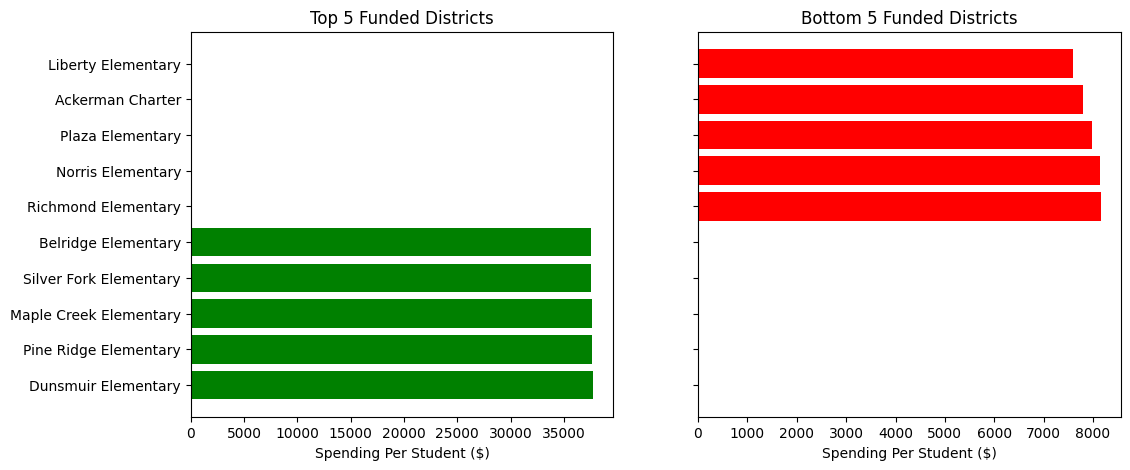

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

df_sorted = df.sort_values(by="Expense_per_Student", ascending=False)

# Top 5 and Bottom 5 Districts
top_5 = df_sorted.head(5)
bottom_5 = df_sorted.tail(6)

# Create bar plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), sharey=True)

# Top 5
axes[0].barh(top_5["District_Name_x"], top_5["Expense_per_Student"], color="green")
axes[0].set_title("Top 5 Funded Districts")
axes[0].set_xlabel("Spending Per Student ($)")
axes[0].invert_yaxis()

# Bottom 5
axes[1].barh(bottom_5["District_Name_x"], bottom_5["Expense_per_Student"], color="red")
axes[1].set_title("Bottom 5 Funded Districts")
axes[1].set_xlabel("Spending Per Student ($)")
axes[1].invert_yaxis()

plt.show()


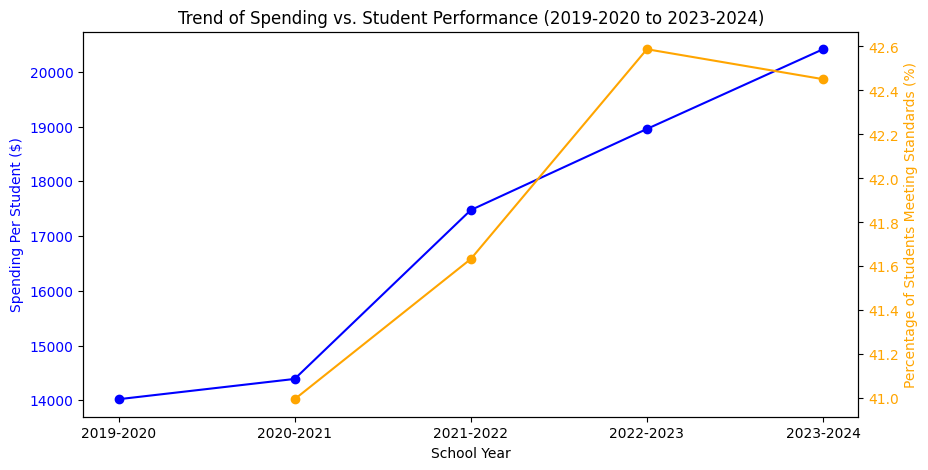

In [7]:
trend = df.groupby("School Year")[["Expense_per_Student", "Percentage Standard Met and Above"]].mean()
trend_filtered = trend[trend.index >= "2019-2020"]

# Update plotting code to use filtered data
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(trend_filtered.index, trend_filtered["Expense_per_Student"], marker="o", color="blue", label="Expense Per Student")
ax1.set_ylabel("Spending Per Student ($)", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(trend_filtered.index, trend_filtered["Percentage Standard Met and Above"], marker="o", color="orange", label="Percentage Meeting Standards")
ax2.set_ylabel("Percentage of Students Meeting Standards (%)", color="orange")
ax2.tick_params(axis="y", labelcolor="orange")

ax1.set_xlabel("School Year")
plt.title("Trend of Spending vs. Student Performance (2019-2020 to 2023-2024)")
plt.show()

In [8]:
correlation = df["Expense_per_Student"].corr(df["Percentage Standard Met and Above"])
print(f"Correlation between Spending Per Student and Performance: {correlation:.2f}")

Correlation between Spending Per Student and Performance: -0.12


A correlation of -0.12 suggests a very weak negative relationship between spending per student and student performance. This means that increasing spending doesn’t necessarily improve performance, and in some cases, higher spending might even correlate with slightly lower performance.



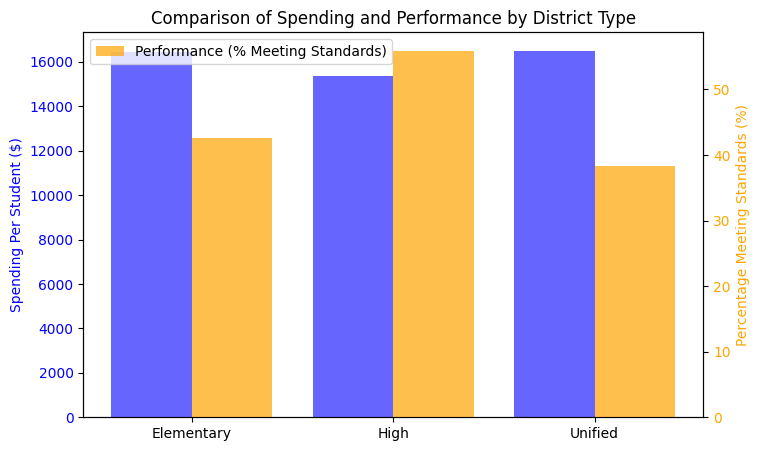

In [9]:
# California districts (Elementary, High, Unified)
df_filtered = df[df["District_Type"].isin(["Elementary", "High", "Unified"])]

# Group by district type and calculate the mean for funding and performance
grouped_data = df_filtered.groupby("District_Type")[
    ["Expense_per_Student", "Percentage Standard Met and Above"]
].mean()


fig, ax1 = plt.subplots(figsize=(8, 5))
bar_width = 0.4
x_labels = grouped_data.index
x_positions = range(len(x_labels))

ax1.bar(
    x_positions, grouped_data["Expense_per_Student"], width=bar_width,
    label="Spending Per Student ($)", color="blue", alpha=0.6
)
ax1.set_ylabel("Spending Per Student ($)", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

ax2 = ax1.twinx()
ax2.bar(
    [x + bar_width for x in x_positions], grouped_data["Percentage Standard Met and Above"],
    width=bar_width, label="Performance (% Meeting Standards)", color="orange", alpha=0.7
)
ax2.set_ylabel("Percentage Meeting Standards (%)", color="orange")
ax2.tick_params(axis="y", labelcolor="orange")

ax1.set_xticks([x + bar_width / 2 for x in x_positions])
ax1.set_xticklabels(x_labels)
plt.title("Comparison of Spending and Performance by District Type")

plt.legend(loc="upper left")
plt.show()




---



---



---

